# Hierarquical classification (binary, ternary and Bethesda results)
Features selected by Multivariate Analysis are here used to validate performance 
We execute the models using a 10-fold cross validation with upsampling of test data. 
The models was built in a hierarquical classifier arranjment as illustrated in the above Figure (b. item)

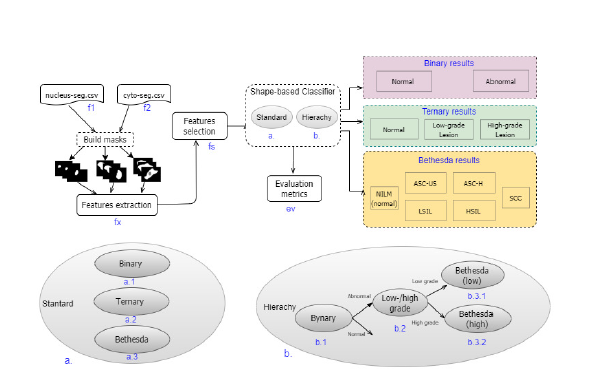

In [1]:
import os
import sys

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))

In [3]:
import numpy as np
import pandas as pd
from math import sqrt
from PIL import Image
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import feature_selection as fs
from sklearn import preprocessing
from datetime import datetime
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE, BorderlineSMOTE
import matplotlib
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import ttest_1samp, ttest_ind, norm
from utils import functions

In [4]:
## Parameters sugested by gridsearch for models (see tuning.ipynb)
svm_param =  {'C': 100, 'kernel': 'linear'}
rf_param = {'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 50}
xgb_param = {'learning_rate': 0.1, 'n_estimators': 86, 'max_depth': 9, 'min_child_weight':1,
              'gamma':0, 'subsample':0.9, 'colsample_bytree':0.7, 'reg_alpha': 0.001}


In [5]:
classifiers = ['SVM', 'RF', 'XGBoost']
params = [svm_param, rf_param, xgb_param]

## Features selected

In [6]:
selected_features = ['areaN', 'extentN', 'RAN', 'Use_curv1N',
                     'solidityC', 'major_axisC', 
                     'area_NC']
id_columns = ['bethesda', 'image_id', 'cell_id']
all_columns = id_columns + selected_features
print(f'Nº total de de features: {len(selected_features)}')

Nº total de de features: 7


### Read data cell features (normalized)

In [7]:
normalized_cell_features= pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), 'files', 'normalized_features.csv'), index_col=0)
normalized_cell_features = normalized_cell_features[all_columns]

In [8]:
df_nilm, df_ascus, df_lsil, df_asch, df_hsil, df_scc = functions.split_per_classes(normalized_cell_features)

--- Samples per class  --- 
NILM.....:  862
ASC-Us...:  286
ASC-H....:  536
LSIL.....:  598
HSIL.....:  874
SCC......:  77
TOTAL....:  3233


In [9]:
# Split in X(data), y(target) and image/cells ids data
data, target, image_cells_ids= functions.split_data_targe_ids(df_nilm, df_ascus, \
                       df_lsil, df_asch, df_hsil,df_scc)
 

In [10]:
labels_list = []
conf_matrix_list = []
roc_curve_list = []

aucs = np.zeros((3))
accs = np.zeros((3))
precs = np.zeros((3))
recs = np.zeros((3))
specs = np.zeros((3))
f1_scores = np.zeros((3))
aucs = np.zeros((3))

# Preditions aux arrays 
preds_to_conf_matrix_bin= []
preds_to_conf_matrix_ter= []
preds_to_conf_matrix_bet= []
labels_list_bin = [] 
roc_curve_list_bin = []

preds_bin = np.ones((data.shape[0],3))*-1
probs_bin = np.zeros((data.shape[0],3,2))
preds_ter = np.ones((data.shape[0],3))*-1
probs_ter = np.zeros((data.shape[0],3,2))
preds_bet = np.ones((data.shape[0],3))*-1
probs_bet = np.zeros((data.shape[0],3,2))

# Dataframe of results
results_bin = pd.DataFrame(np.empty((3,10), dtype=object), columns=['Experiment', 'Model', 'Features', 'Accuracy', 'Precision', 'Recall' , 'False Pos', 'False Neg', 'Specificity', 'F1_measure'])
results_ter = pd.DataFrame(np.empty((3,10), dtype=object), columns=['Experiment', 'Model', 'Features', 'Accuracy', 'Precision', 'Recall' , 'False Pos', 'False Neg','Specificity', 'F1_measure'])
results_bet = pd.DataFrame(np.empty((3,10), dtype=object), columns=['Experiment', 'Model', 'Features', 'Accuracy', 'Precision', 'Recall' , 'False Pos', 'False Neg','Specificity', 'F1_measure'])

# Transformations of labels in each level
le_2 = preprocessing.LabelEncoder()
le_2.fit([1,2])
le_3 = preprocessing.LabelEncoder()
le_3.fit([1,2])
le_4 = preprocessing.LabelEncoder()
le_4.fit([3,4,5])

classifiers = ['SVM', 'RF', 'XGBoost']
features_desc= "features N/C"
N_SPLITS = 10 

mean_fpr = np.linspace(0, 1, 100)
data = data[selected_features]

In [11]:
# Loop principal:  (cross_val )
start_t = functions.timer()

cv = StratifiedKFold(n_splits=10, random_state=None)
for it, (idx_train, idx_test) in enumerate(cv.split(data.values, target['bethesda'].values)):
    print('Iter number: ', it)

    # Filter lines for X an y(target) in each fold
    X_train = data.values[idx_train]
    y_train = target['binary'].values[idx_train]
    
    X_test = data.values[idx_test]
    y_test = target['binary'].values[idx_test]
                                                   
    ## Train and evaluation of models for classifier 1:
    for i in range(3):   
        ## Binary classification (level 0)
        model = functions.getModel(params= params[i], classifier = classifiers[i], class_type = 'binary')
        _, model = functions.fit_model(X_train, y_train, model, cls_type= 1)
        # Predição:
        pred_y = np.empty(len(idx_test)) 
        pred_y = model.predict(X_test)
        prob_y = model.predict_proba(X_test)

        # Registra predições:
        preds_bin[idx_test, i] = pred_y
        probs_bin[idx_test, i] = prob_y
        
        # Registra predições (classicações ternária/bethesda):
        idx_0 = functions.index_pred_from_class(idx_test, pred_y, cls=0)
        preds_ter[idx_0, i] =  preds_bin[idx_0, i]
        probs_ter[idx_0, i] =  probs_bin[idx_0, i] 
        preds_bet[idx_0, i] =  preds_bin[idx_0, i]
        probs_bet[idx_0, i] =  probs_bin[idx_0, i]  

    ##------------ X ------------- 
    ## Ternary classification (level 1)
    
    ## Seleciona amostras para treino/teste
    # Treino: seleciona apenas amostras do conjunto de treino para rótulos ternários 1 e 2, filtrando 
    # apenas features selecionadas para o classificador 2
    X_df_train2, y_df_train2 = functions.filter_dataXY(data.loc[idx_train],
                                       target.loc[idx_train], 2)
    X_train2, y_train2 = X_df_train2.values,  y_df_train2.values
        
    for i in range(3):   
        ## Obtem dados para teste de acordo com a predição de cada modelo do classificador 1
        # Teste: filtra amostras de rótulos 1 das predições do classificador 1  
        idx_test2, X_df_test2, y_df_test2 = functions.filter_Xy_from_cls1_to_cls2(data.loc[idx_test],
                                                        target.loc[idx_test], preds_bin[:,i], idx_test)
        
        X_test2, y_test2= X_df_test2.values, y_df_test2.values
 
        ## Obtem modelo
        model = functions.getModel(params= params[i], classifier = classifiers[i], class_type = 'binary')
        _, model = functions.fit_model(X_train2, y_train2, model, cls_type= 2)
           
        # Predição:
        pred2_y = np.empty(len(idx_test2))
        pred2_y = model.predict(X_test2)
        print()
        pred2_y = le_2.inverse_transform(pred2_y)
        #prob_y = model.predict_proba(X_test2)

        # Registra predições:
        preds_ter[idx_test2, i] = pred2_y
        #probs_ter[idx_test2, i] = prob_y        
        
    ##------------ X ------------- 
    ## Classificador 2.1: ASC-US/LSIL  
    
    ## Seleciona amostras para treino/teste
    # Treino: seleciona apenas amostras do conjunto de treino para rótulos bethesda 1 e 3, filtrando 
    # apenas features selecionadas para o classificador 3
    X_df_train3, y_df_train3 = functions.filter_dataXY(data.loc[idx_train],
                                       target.loc[idx_train], 3)
    X_train3, y_train3 = X_df_train3.values,  y_df_train3.values
    
    for i in range(3):   
        ## Obtem dados para teste de acordo com a predição de cada modelo do classificador 2
        # Filtra amostras de rótulos 1 (lesão de baixo grau) das predições dos classificadores 2  
        idx_test3, X_df_test3, y_df_test3 = functions.filter_Xy_from_cls1_to_cls3(data.loc[idx_test],
                                                        target.loc[idx_test], preds_ter[:,i], idx_test)
        
        X_test3, y_test3= X_df_test3.values, y_df_test3.values
 
        ## Obtem modelo
        model = functions.getModel(params= params[i], classifier = classifiers[i], class_type = 'binary')
        _, model = functions.fit_model(X_train3, y_train3, model, cls_type= 3)
        #print('--metricas Classificador 3 :', i, metr)
        
        # Predição:
        pred3_y = np.empty(len(idx_test3))
        pred3_y = model.predict(X_test3)
        pred3_y = le_3.inverse_transform(pred3_y)
        #prob_y = model.predict_proba(X_test3)

        # Registra predições:
        preds_bet[idx_test3, i] = pred3_y
        #probs_bet[idx_test3, i] = prob_y
        
    ##------------ X ------------- 
    ## Classificador 2.2: ASC-H/HSIL/Car
    
    ## Seleciona amostras para treino/teste
    # Treino: seleciona apenas amostras do conjunto de treino para rótulos bethesda 2,4,5, filtrando 
    # apenas features selecionadas para o classificador 4
    X_df_train4, y_df_train4 = functions.filter_dataXY(data.loc[idx_train],
                                       target.loc[idx_train], 4)
    X_train4, y_train4 = X_df_train4.values,  y_df_train4.values
    
    
    for i in range(3):   
        ## Obtem dados para teste de acordo com a predição de cada modelo do classificador 2
        # Filtra amostras de rótulos 2(lesão de alto grau) das predições dos classificadores 2  
        idx_test4, X_df_test4, y_df_test4 = functions.filter_Xy_from_cls2_to_cls4(data.loc[idx_test],
                                                        target.loc[idx_test], preds_ter[:,i], idx_test)
        
        X_test4, y_test4= X_df_test4.values, y_df_test4.values
 
        ## Obtem modelo
        model = functions.getModel(params= params[i], classifier = classifiers[i], class_type = 'ternary')
        metr, model = functions.fit_model(X_train4, y_train4, model, cls_type= 4)
        #print('metricas :', i, metr)
        
        # Predição:
        pred4_y = np.empty(len(idx_test4))
        pred4_y = model.predict(X_test4)
        pred4_y = le_4.inverse_transform(pred4_y)
        #prob_y = model.predict_proba(X_test4)

        # Registra predições:
        preds_bet[idx_test4, i] = pred4_y
        #probs_bet[idx_test4, i] = prob_y
 
## Resultados - classificação binária (normal/anormal):
# Calcula curva_roc e AUC:
for i in range(3):   
    prob = probs_bin[:, i, 1]
    fpr, tpr, thresholds = roc_curve(target['binary'].values, prob)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    aucs[i]= auc(mean_fpr, interp_tpr)
    labels_list_bin.append(r"ROC Curve (AUC %s= %0.4f)" % ((classifiers[i]+"- normal/anormal"), aucs[i]))
    roc_curve_list_bin.append((mean_fpr, interp_tpr))
    
    # Calcula e registra métricas p/ fold:
    accs[i] = functions.calc_metric(target['binary'].values, preds_bin[:,i], metric_type='acc', class_type='binary', pos_label=1, classes=[0,1])
    precs[i] = functions.calc_metric(target['binary'].values, preds_bin[:,i], metric_type='prec',class_type='binary')                
    recs[i] = functions.calc_metric(target['binary'].values, preds_bin[:,i], metric_type='rec',class_type='binary')                
    specs[i] = functions.calc_metric(target['binary'].values, preds_bin[:,i], metric_type='spec',class_type='binary')                
    f1_scores[i] = functions.calc_metric(target['binary'].values, preds_bin[:,i], metric_type='f1_score',class_type='binary')        
    # Acumula métricas no dataframe de resultados e agrupa curvas ROC para exibição:
    metrics= {'Model': classifiers[i], 'acc': accs[i], 'prec': precs[i], 'rec': recs[i], 
              'spec': specs[i], 'f1_score': f1_scores[i], 'AUC': aucs[i]}                                      
    results_bin.loc[i] = functions.fill_line_metrics_CV(classifiers[i], features_desc, i, metrics, results_bin, class_type='1- Normal/Anormal')            
    # Acumula Matrizes de confusão:  https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix
    preds_to_conf_matrix_bin.append((target['binary'].values, preds_bin[:,i], "1. Normal/Anormal -"+str(classifiers[i])))
            
  
## Resultados - classificação ternária (normal/baixo grau/ alto grau)
# Calcula métricas e matrix de confusão:
for i in range(3):       
    # Calcula e registra métricas p/ fold:
    accs[i] = functions.calc_metric(target['ternary'].values, preds_ter[:,i], metric_type='acc', class_type='ternary', classes=[0,1,2])
    precs[i] = functions.calc_metric(target['ternary'].values, preds_ter[:,i], metric_type='prec',class_type='ternary', classes=[0,1,2])                
    recs[i] = functions.calc_metric(target['ternary'].values, preds_ter[:,i], metric_type='rec',class_type='ternary', classes=[0,1,2])                
    specs[i] = functions.calc_metric(target['ternary'].values, preds_ter[:,i], metric_type='spec',class_type='ternary', classes=[0,1,2])                
    f1_scores[i] = functions.calc_metric(target['ternary'].values, preds_ter[:,i], metric_type='f1_score',class_type='ternary', classes=[0,1,2])        
    # Acumula métricas no dataframe de resultados e agrupa curvas ROC para exibição:
    metrics= {'Model': classifiers[i], 'acc': accs[i], 'prec': precs[i], 'rec': recs[i], 
              'spec': specs[i], 'f1_score': f1_scores[i], 'AUC': aucs[i]}                                      
    results_ter.loc[i] = functions.fill_line_metrics_CV(classifiers[i], features_desc, i, metrics, results_ter, class_type='2- Normal/Low G./High G.')            
    # Acumula Matrizes de confusão:  https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix
    preds_to_conf_matrix_ter.append((target['ternary'].values, preds_ter[:,i], "2- Normal/Low G./High G. -"+str(classifiers[i])))

    
## Resultados - classificação bethesda (normal/ascus/asch/lsil/hsil/car)
# Calcula métricas e matrix de confusão:
for i in range(3):   
    # Calcula e registra métricas p/ fold:
    accs[i] = functions.calc_metric(target['bethesda'].values, preds_bet[:,i], metric_type='acc', class_type='bethesda', classes=[0,1,2,3,4,5])
    precs[i] = functions.calc_metric(target['bethesda'].values, preds_bet[:,i], metric_type='prec',class_type='bethesda', classes=[0,1,2,3,4,5])                
    recs[i] = functions.calc_metric(target['bethesda'].values, preds_bet[:,i], metric_type='rec',class_type='bethesda', classes=[0,1,2,3,4,5])                
    specs[i] = functions.calc_metric(target['bethesda'].values, preds_bet[:,i], metric_type='spec',class_type='bethesda', classes=[0,1,2,3,4,5])                
    f1_scores[i] = functions.calc_metric(target['bethesda'].values, preds_bet[:,i], metric_type='f1_score',class_type='bethesda', classes=[0,1,2,3,4,5])        
    # Acumula métricas no dataframe de resultados e agrupa curvas ROC para exibição:
    metrics= {'Model': classifiers[i], 'acc': accs[i], 'prec': precs[i], 'rec': recs[i], 
              'spec': specs[i], 'f1_score': f1_scores[i], 'AUC': aucs[i]}                                      
    results_bet.loc[i] = functions.fill_line_metrics_CV(classifiers[i], features_desc, i, metrics, results_bet, class_type='3- Bethesda')            
    # Acumula Matrizes de confusão:  https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix
    preds_to_conf_matrix_bet.append((target['bethesda'].values, preds_bet[:,i], "3- Bethesda -"+str(classifiers[i])))

functions.timer(start_t)

Iter number:  0
Iter number:  1
Iter number:  2
Iter number:  3
Iter number:  4
Iter number:  5
Iter number:  6
Iter number:  7
Iter number:  8
Iter number:  9

 Time taken: 0 hours 0 minutes and 59.95 seconds.


In [12]:
preds_bet[800:950,0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 5., 0., 0., 0., 0., 0., 0., 1., 3., 1., 1., 3., 2.,
       1., 5., 0., 3., 1., 1., 5., 1., 3., 1., 3., 0., 0., 1., 1., 3., 1.,
       1., 3., 3., 1., 1., 1., 3., 3., 3., 3., 3., 3., 3., 3., 1., 3., 3.,
       3., 1., 1., 0., 1., 3., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 1., 1., 1., 3., 0., 1., 3., 0., 3., 3., 1.,
       1., 3., 3., 0., 1., 0., 0., 0., 0., 3., 1., 1., 1., 1.])

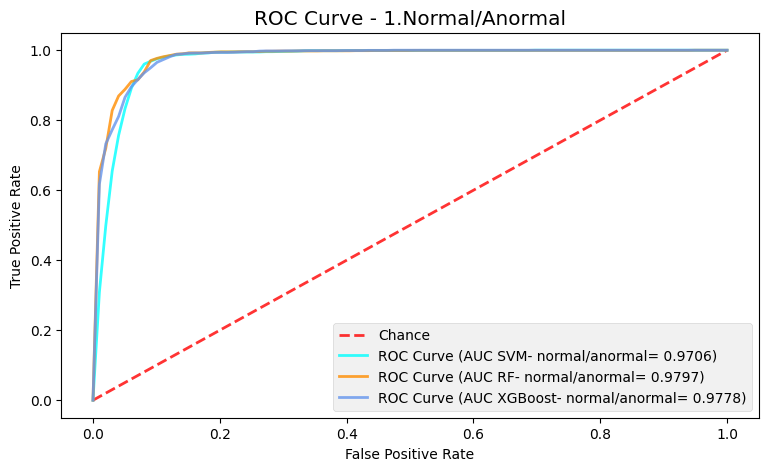

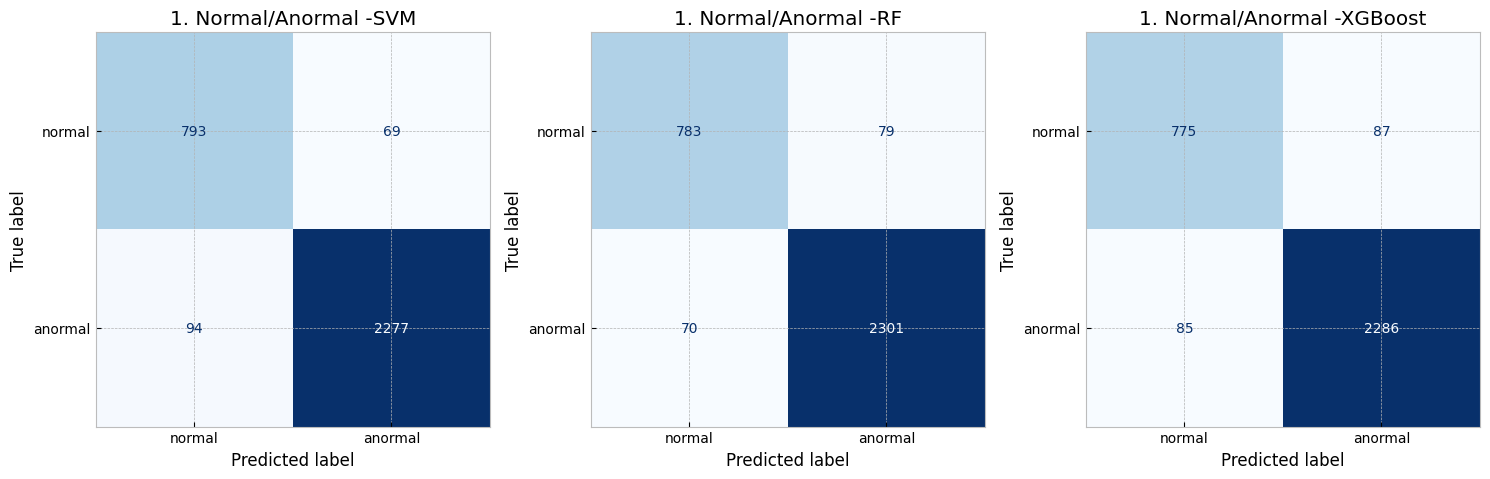

,Experiment,Model,Features,Accuracy,Precision,Recall,False Pos,False Neg,Specificity,F1_measure
0,1- Normal/Anormal,SVM,features N/C,0.9496,0.9706,0.9604,0.0800,0.0396,0.9200,0.9654
1,1- Normal/Anormal,RF,features N/C,0.9539,0.9668,0.9705,0.0916,0.0295,0.9084,0.9686
2,1- Normal/Anormal,XGBoost,features N/C,0.9468,0.9633,0.9642,0.1009,0.0358,0.8991,0.9637


In [13]:
# Exibe curvas roc, matrizes de confusão e métricas - Classificador binário:
functions.plot_roc_curve_CV(roc_curve_list_bin, labels_list_bin, title = "ROC Curve - 1.Normal/Anormal")
functions.plot_conf_matrix(preds_to_conf_matrix_bin, lbls=[0,1], disp_lbls=['normal', 'anormal'])
results_bin


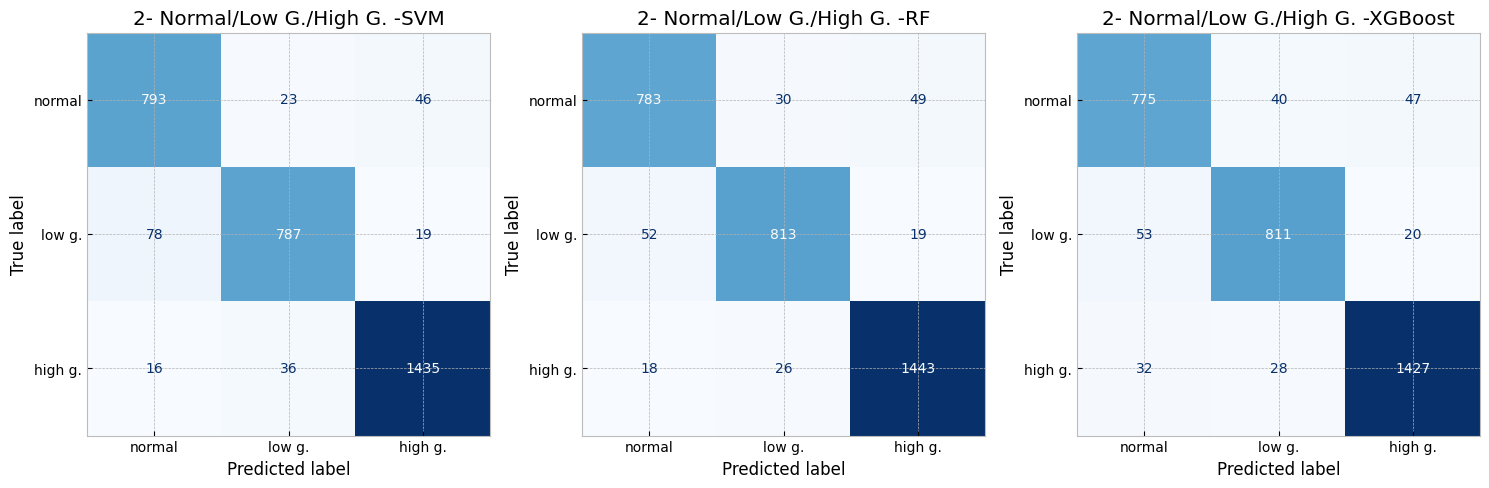

,Experiment,Model,Features,Accuracy,Precision,Recall,False Pos,False Neg,Specificity,F1_measure
0,2- Normal/Low G./High G.,SVM,features N/C,0.9326,0.9327,0.9326,0.0340,0.0674,0.9660,0.9325
1,2- Normal/Low G./High G.,RF,features N/C,0.9400,0.9398,0.9400,0.0308,0.0600,0.9692,0.9398
2,2- Normal/Low G./High G.,XGBoost,features N/C,0.9320,0.9319,0.9320,0.0344,0.0680,0.9656,0.9319


In [14]:
# Exibe matrizes de confusão e métricas - Classificador ternário:
functions.plot_conf_matrix(preds_to_conf_matrix_ter, lbls=[0,1,2], disp_lbls=['normal','low g.', 'high g.'])
results_ter

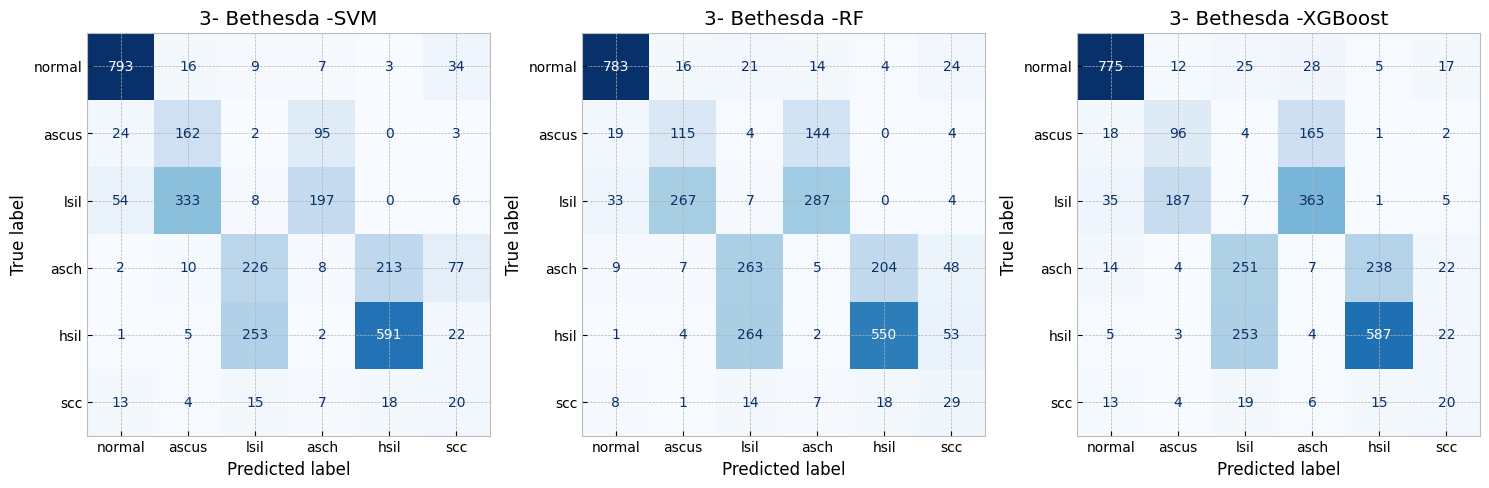

,Experiment,Model,Features,Accuracy,Precision,Recall,False Pos,False Neg,Specificity,F1_measure
0,3- Bethesda,SVM,features N/C,0.4893,0.4691,0.4893,0.1024,0.5107,0.8976,0.4747
1,3- Bethesda,RF,features N/C,0.4606,0.4695,0.4606,0.1085,0.5394,0.8915,0.4626
2,3- Bethesda,XGBoost,features N/C,0.4615,0.4651,0.4615,0.1097,0.5385,0.8903,0.4632


In [15]:
# Exibe matrizes de confusão e métricas - Classificador ternário:
functions.plot_conf_matrix(preds_to_conf_matrix_bet, lbls=[0,1,2,3,4,5], disp_lbls=['normal','ascus', 'lsil', 'asch', 'hsil', 'scc'])
results_bet